# Implementation on the nWAM data

Our implementation based on the work of the authors. We use the same module as coded in the JobTraining ipt. __Please Note that the current implementation is in Python 2.7 and can not be ported as is to Python 3__. We recommend setting a virtual environment [(How to do it on Ubuntu)](https://askubuntu.com/questions/244641/how-to-set-up-and-use-a-virtual-python-environment-in-ubuntu) to run this notebook.

As for the supplementary notebook provided with the article, we recommend to run this notebook in a folder containing the files of the __ipt__ package rather than try to install it


In [1]:
from ols import ols
from logit import logit
from att import att

In [2]:
%pylab inline

import warnings
warnings.filterwarnings('ignore') # Remove pandas warnings

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
import seaborn as sns 


from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.rcParams["figure.figsize"] = (15,6) # Run twice or it won't work

In [4]:
plt.rcParams["figure.figsize"] = (15,6) # Run twice or it won't work

In [5]:
df = pd.read_csv("nWAN_data.csv")

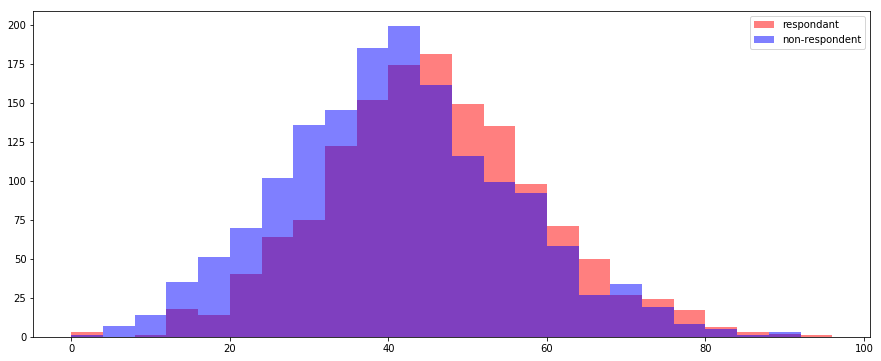

In [6]:
D = (df.Participant == "Yes")

# Plot an histogram for follow up and not follow up
plt.hist(df.FCS_score[D], bins= np.arange(0,100, 4), alpha=0.5, color='r', label='respondant')
plt.hist(df.FCS_score[~D], bins= np.arange(0,100, 4), alpha=0.5, color= 'b', label = 'non-respondent')
plt.legend(loc='upper right')
plt.show()

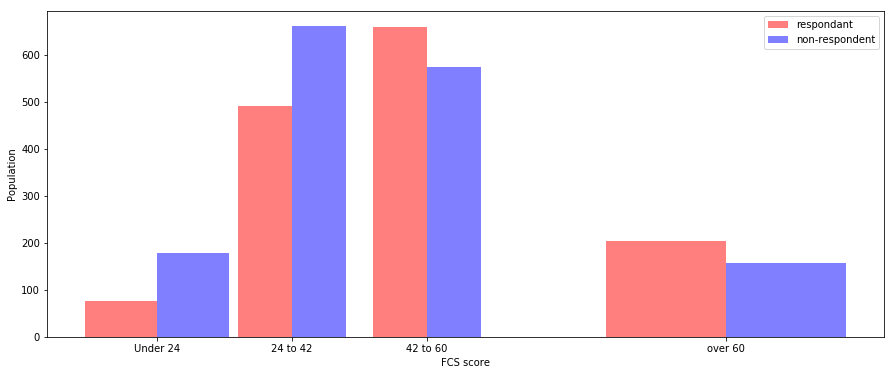

In [8]:
plt.hist([df.FCS_score[D], df.FCS_score[~D]], bins= [0, 24, 42, 60, 100], alpha=0.5, color=['r', 'b'], 
         label=['respondant', 'non-respondent'], align='right')
plt.legend()
plt.ylabel("Population")
plt.xlabel("FCS score")
plt.xticks([24, 42, 60, 100], ["Under 24", "24 to 42", "42 to 60", "over 60"])
plt.savefig("repartition_FCS_score.png")
plt.show()

We see that there is a distribution difference between our respondent and non-respondent populations, it can even more so be observed when we use the official separation between food security scores:

 - The first category (under 24) is considered as "insufficient"
 - The second one (24 to 42) is "borderline"
 - The last one (over 42) is "acceptable"
 
We want to check if tilting our background covariate for respondents can make the two distributions coincide.

We separate the food security score into the official categories, and furthermore break the "acceptable" category in two more smaller subcategories - 42 to 60 and over 60- to have more comparison points.

In [8]:
# Select some usable variables
df_ast = df[['Depense_Alimentaire', 'Depense_non_Alimentaire', 'Taille_menage', "age_chef_menage",
             'Alphabetisation', 'sexe_chef_menage', 'FCS_score']]

df_ast['constant'] = 1

df_ast['age_chef_menage'] /= 10
df_ast[['Depense_Alimentaire', 'Depense_non_Alimentaire']] /= 1000
df_ast['Alphabetisation'] = (df_ast['Alphabetisation'] == "oui").astype(float)
df_ast['sexe_chef_menage'] = (df_ast['sexe_chef_menage'] == 'Femme').astype(float)


## Checking the convex hull

We check the convex hull on the food and non-food spending. Even though the mean of the "treatment" group (the respondents to the phone survey) seem close to the control group's convex hull bound, means of treatment and control are also pretty close, meaning that a reweighing on these variables  aiming at equating both means would be minimal.

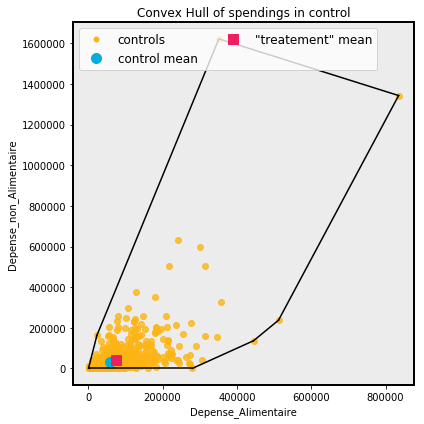

In [9]:
# Shameless copypaste of the convex hull in the author's notebook

from scipy.spatial import ConvexHull

# Extract pre-treatment earnings for NSW treated units and PSID controls
earnings_treatment = np.asarray(df[D][['Depense_Alimentaire','Depense_non_Alimentaire']])
earnings_control   = np.asarray(df[~D][['Depense_Alimentaire','Depense_non_Alimentaire']])

# Calculate convex hull of PSID control units' earnings realizations
hull = ConvexHull(earnings_control)

# Create a figure object to plot the convex hull
convexhull_fig = plt.figure(figsize=(6, 6))    

# Scatter plot of pre-treatment earnings in 1974 and 1975 for PSID controls
ax = convexhull_fig.add_subplot(1,1,1)
sns.regplot(x="Depense_Alimentaire", y="Depense_non_Alimentaire", data=df[~D], \
            fit_reg=False, color='#FDB515')
plt.title('Convex Hull of spendings in control', fontsize=12)
plt.xlabel('Depense_Alimentaire')
plt.ylabel('Depense_non_Alimentaire')


# Plot mean earnings for NSW treated units and PSID controls
plt.plot(np.mean(earnings_control[:,0]), np.mean(earnings_control[:,1]), \
         color='#00B0DA', marker='o', markersize=10)
plt.plot(np.mean(earnings_treatment[:,0]), np.mean(earnings_treatment[:,1]), \
         color='#EE1F60', marker='s', markersize=10)

# Plot convex hull
for simplex in hull.simplices:
    plt.plot(earnings_control[simplex, 0], earnings_control[simplex, 1], 'k-')

# Clean up the plot, add frames, remove gridlines etc.
ax = plt.gca()
ax.patch.set_facecolor('gray')               # Color of background
ax.patch.set_alpha(0.15)                     # Translucency of background
ax.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('k')
    ax.spines[spine].set_linewidth(2)

# Add legend to the plot
import matplotlib.lines as mlines

psid_patch      = mlines.Line2D([], [], color='#FDB515', marker='o', linestyle='None',\
                                markersize=5, label='controls')
psid_mean_patch = mlines.Line2D([], [], color='#00B0DA', marker='o', linestyle='None',\
                                markersize=10, label='control mean')
nsw_mean_patch  = mlines.Line2D([], [], color='#EE1F60', marker='s', linestyle='None',\
                                markersize=10, label='"treatement" mean')

lgd = plt.legend(handles=[psid_patch, psid_mean_patch, nsw_mean_patch], \
                          loc='upper left', fontsize=12, ncol=2, numpoints = 1) 
        
# Render & save plot
plt.tight_layout()
#plt.savefig(workdir+'Fig_LaLonde_Convex_Hull.png')

## Defining a bootstrap function

Bootstrap is used in the Matlab code to determine standard error on proportions of Black and White under certain thresholds, we reproduce it here

In [12]:
def bootstrap_ast(df, variables, D, Y, groups, n_iter=1000, rglrz=1 ):
    """
    Sample with replacement a sample of the same size as the original data and compute the AST tilt based on this.
    It is assumed there that t(W) = r(W), and thus we compute only the tilting for the control sample.
    df : dataframe containing the variables
    variables: name of the variables to use the AST on
    D: array of the treatment and control group
    groups: list of bounds separating the different groups we want to make our probabilities on
    n_iter: number of iterations
    rglrz : regularization parameter for the tilting"""
    size_sample = len(df)
    
    list_probs = []
    # Check if the name of the variable Y is given or the array
    if type(Y) == str:
        Y = df[Y]
    
    h_W = df[variables]
    
    for i in range(n_iter):
        sample_idx = np.random.choice(np.arange(size_sample), size_sample, 
                                      replace=True)
        # Select dataframe by index
        h_W_sel = df.loc[sample_idx, variables]
    
        t_W_sel = h_W_sel
        
        # We can directly select the index since this is a numpy array
        Y_sel = Y[sample_idx]
        D_sel = D[sample_idx]
        
        [gamma_ast, vcov_gamma_ast, pscore_tests, tilts, exitflag] = \
                                            att(D_sel, Y_sel, h_W_sel, t_W_sel, study_tilt = False, 
                                                rlgrz = rglrz, silent=True)
        if exitflag != 1:
            raise ValueError('Exit flag %s' % exitflag)
    
        # Compute the probabilities given the tilts for each selection
        sum_weigths = sum(tilts[:, 2]) # Weigths of study sample are 0 there so we can sum
        bounds_prob = []
        for bound in groups:
            # We only have to check the tilt of the control group since we don't tilt the study
            prob = sum(tilts[(Y_sel < bound) & (D_sel == 0), 2])/sum_weigths
            bounds_prob.append(prob)
        list_probs.append(bounds_prob)
    
    return np.array(list_probs)


## Tilting on a few variables

Here we select only very few variables, simply to try if the tilting works on our variables

In [11]:
res = bootstrap_ast(df_ast, ["constant", "Taille_menage", "Depense_Alimentaire", "sexe_chef_menage", 'Alphabetisation'], 
                    D, 'FCS_score', [24, 42, 60], n_iter=1000, rglrz=1)

# Try with a lower regularizer
res_half_rglrz = bootstrap_ast(df_ast, ["constant", "Taille_menage", "Depense_Alimentaire", "sexe_chef_menage", 'Alphabetisation'], 
                    D, 'FCS_score', [24, 42, 60], n_iter=1000, rglrz=1/2)

Check computation time

In [12]:
%%timeit 
bootstrap_ast(df_ast, ["constant", "Taille_menage", "Depense_Alimentaire", "sexe_chef_menage", 'Alphabetisation'], 
                       D, 'FCS_score', [24, 42, 60], n_iter=100, rglrz=1)

1 loop, best of 3: 11.4 s per loop


In [13]:
%%timeit
res_half_rglrz = bootstrap_ast(df_ast, ["constant", "Taille_menage", "Depense_Alimentaire", "sexe_chef_menage", 'Alphabetisation'], 
                    D, 'FCS_score', [24, 42, 60], n_iter=100, rglrz=1/2)

1 loop, best of 3: 12.5 s per loop


## Present the results

As we can see below, even though there seem to be that no optimal tilt was found to make tilter control distribution and respondents distribution exactly coincide, using only a few covariates from our dataset seem to already correct the control distribution to make it closer to the respondents'.

As the results show, there seem to be little difference -except computing time - between using the default regularization parameter or 1/2 as the authors did. This comforts our idea that overlap is good enough in our data

In [17]:
bounds = [24, 42, 60]

bounds_treat = []
bounds_control = []

Y = df_ast['FCS_score']

for b in bounds:
    # Every weight is assumed to be 1 at the beginning
    
    # Check repartition in treatment group
    b_treat = sum(Y[D] < b)/len(Y[D])
    bounds_treat.append(b_treat)
    
    # Check repartition in control group
    b_control = sum(Y[~D] < b)/len(Y[~D])
    bounds_control.append(b_control)
 

In [ ]:
df_res = pd.DataFrame(data={'Respondents' : bounds_treat,
                            'Non Respondents' : bounds_control,
                            'Tilted non Respondents': res.mean(axis=0),
                            'Tilted non Respondents std. err.': res.std(axis=0),
                            '1/2 regularizer Tilted non Respondents': res_half_rglrz.mean(axis=0),
                            '1/2 regularizer std. err.': res_half_rglrz.std(axis=0)},
                     index=['Pr(FCS_score < 24)', 'Pr(FCS_score < 42)', 'Pr(FCS_score < 60)'])

In [15]:
df_res[['Respondents', 'Non Respondents', 
        'Tilted non Respondents', 'Tilted non Respondents std. err.',
        '1/2 regularizer Tilted non Respondents', '1/2 regularizer std. err.']]

,Respondents,Non Respondents,Tilted non Respondents,Tilted non Respondents std. err.,1/2 regularizer Tilted non Respondents,1/2 regularizer std. err.
Pr(FCS_score < 24),0.053184,0.113448,0.098644,0.007786,0.098205,0.007675
Pr(FCS_score < 42),0.396781,0.534736,0.484393,0.014964,0.485639,0.015560
Pr(FCS_score < 60),0.857943,0.900574,0.870136,0.011118,0.870652,0.010785


In [28]:
print(df_res[['Respondents', 'Non Respondents', 
        'Tilted non Respondents', 'Tilted non Respondents std. err.']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Respondents &  Non Respondents &  Tilted non Respondents &  Tilted non Respondents std. err. \\
\midrule
Pr(FCS\_score < 24) &     0.053184 &         0.113448 &                0.098644 &                          0.007786 \\
Pr(FCS\_score < 42) &     0.396781 &         0.534736 &                0.484393 &                          0.014964 \\
Pr(FCS\_score < 60) &     0.857943 &         0.900574 &                0.870136 &                          0.011118 \\
\bottomrule
\end{tabular}



## Working on categorical variables

With the way the att module is coded, there is no way to simply put categorical variables inside it and hope it works.

We work around this hurdle by using dummies on every modalities when accounting for categorical variables.

### What about ordered variables ?

Some categorical variables -such as education- can be ordered from lowest to highest. Using the same solution as normal categorical variables should be enough, however we also propose "ordered dummies", that is, several dummies that are equal to 1 if e.g the individual has attained this level or education or higher and 0 otherwise.

We code a function that can be used to "order" those dummies, however we notice that using it tends to yield non-invertible matrices, so we actually don't use it


In [9]:
def order_dummify(df, ordered_dummies, prefix=None):
    """order dummies so that in a hierachical modalities setting, 
        a modality corresponds to its dummy and every dummy under it equal to 1.
        df: DataFrame which contains the dummies
        ordered_dummies: list of the hierarchy on this categorical variable, from lowest to highest
        prefix: if there is a prefix before every modality (as it can be the case when using pd.get_dummies), automatically add it
    """
    df = df.copy() # Make sure we don't modify the previous DataFrame
    if prefix :
        ordered_dummies = [prefix + '_' + mod for mod in ordered_dummies]
    
    # Put the in reverse order
    ordered_dummies.reverse()
    
    # Compare a category and the one directly under it
    for high, low in zip(ordered_dummies[:-1], ordered_dummies[1:]):
        df[low] = df[high] | df[low]
    
    return df

## Tilting on more variables for W

We want to check both if adding more variables to our implementation would lead to a better tilt and the affirmation from the authors that the AST can be used with a high-dimensional W.

If most of the time the computation runs fine, we can rarely encounter an error because the sample yields a non-invertible matrix. As it happens randomly depending on the draw of the bootstrap and

In [10]:
df_ast = df[["Taille_menage", "sexe_chef_menage", "niveau_edu_chef", "age_chef_menage", 'Volume_eaupot_parpersonne',
             "q24_Situat_matri_cm", "pourcent_age0_5ans", "Alphabetisation", 'q27a_nbre_personnes_inactif',
             "q39_biens_fonctionnlsq392_tlvsr", "nb_enfant_6_59_mois", "pourcents_femme", 'asin', 'equin', 'caprin',
             'ovin', 'bovin',"tel_portable", "WallType", "FCS_score", "Taux_promiscuite"]]

df_ast['constant'] = 1

# List of the variables we are going to use in the AST
list_variables = ['constant', "Taille_menage", "q39_biens_fonctionnlsq392_tlvsr", "age_chef_menage",
                  'q27a_nbre_personnes_inactif', 'asin', 'equin', 'caprin', 'ovin', 'bovin',
                  "nb_enfant_6_59_mois", "pourcents_femme", "pourcent_age0_5ans", 'Volume_eaupot_parpersonne',
                  "tel_portable", "Taux_promiscuite"]

df_ast["betail"] = df_ast[['asin', 'equin', 'caprin', 'ovin', 'bovin']].sum(axis=1)
list_variables.append("betail")


# Recode binary and categorical variables
df_ast["sexe_chef_menage"] = (df_ast["sexe_chef_menage"] == "Femme").astype(float)
df_ast['Alphabetisation'] = (df_ast['Alphabetisation'] == "oui").astype(float)
list_variables += ['sexe_chef_menage', 'Alphabetisation']

# Add ordered dummies on education
edu_dummies = pd.get_dummies(df_ast['niveau_edu_chef'], prefix="edu")
edu_order= ["None", "Primary - First cycle", "Primary - Second cycle", "Secondary", "Litterate - Qur'anic", 'Higher']
df_ast = df_ast.merge(edu_dummies, left_index=True, right_index=True)
list_variables += list(edu_dummies)

# Add dummies on marital situation
marital_dummies = pd.get_dummies(df_ast['q24_Situat_matri_cm'], prefix="marital")
df_ast= df_ast.merge(marital_dummies, left_index=True, right_index=True)

list_variables += list(marital_dummies)

# Add dummies on Walltype
wall_dummies = pd.get_dummies(df_ast['WallType'], prefix='wall') # No real order
df_ast = df_ast.merge(wall_dummies, left_index=True, right_index=True)

list_variables += list(wall_dummies)

In [14]:
# Because of the low std err found previously, we compute less iterations for faster computing
res_big = bootstrap_ast(df_ast, list_variables,  D, 'FCS_score', [24, 42, 60], 
                        n_iter=100, rglrz=1/2) 

In [19]:
df_res_big = pd.DataFrame(data={'Respondents' : bounds_treat,
                            'Non Respondents' : bounds_control,
                            'Tilted non Respondents': res_big.mean(axis=0),
                            'Tilted non Respondents std. err.': res_big.std(axis=0)},
                     index=['Pr(FCS_score < 24)', 'Pr(FCS_score < 42)', 'Pr(FCS_score < 60)'])

# Order the columns
df_res_big[['Respondents', 'Non Respondents', 'Tilted non Respondents', 'Tilted non Respondents std. err.']]

,Respondents,Non Respondents,Tilted non Respondents,Tilted non Respondents std. err.
Pr(FCS_score < 24),0.053184,0.113448,0.083963,0.007270
Pr(FCS_score < 42),0.396781,0.534736,0.466950,0.016078
Pr(FCS_score < 60),0.857943,0.900574,0.857733,0.011796


In [25]:
print(df_res_big[['Respondents', 'Non Respondents', 
            'Tilted non Respondents', 'Tilted non Respondents std. err.']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Respondents &  Non Respondents &  Tilted non Respondents &  Tilted non Respondents std. err. \\
\midrule
Pr(FCS\_score < 24) &     0.053184 &         0.113448 &                0.083963 &                          0.007270 \\
Pr(FCS\_score < 42) &     0.396781 &         0.534736 &                0.466950 &                          0.016078 \\
Pr(FCS\_score < 60) &     0.857943 &         0.900574 &                0.857733 &                          0.011796 \\
\bottomrule
\end{tabular}



## Estimating and plotting the densities

We estimate our densities through a gaussian kernel

In [20]:
def KDE_evaluate(data, grid, **kwargs):
    """Generate the evaluations of density for a gaussian kernel"""
    gaussian_evaluator = KDEUnivariate(data)
    gaussian_evaluator.fit(bw=2, **kwargs)
    
    return gaussian_evaluator.evaluate(grid)

In [21]:
# Estimating the density of the tilted distribution
size_sample = len(df)
    
list_probs = []
# Check if the name of the variable Y is given or the array
if type(Y) == str:
    Y = df[Y]
    
h_W = df_ast[list_variables]
    
t_W = h_W

# We can directly select the index since this is a numpy array

[gamma_ast, vcov_gamma_ast, pscore_tests, tilts, exitflag] = \
                                    att(D, Y, h_W, t_W, study_tilt = False, 
                                        rlgrz = 1, silent=True)
if exitflag != 1:
    raise ValueError('Exit flag %s' % exitflag)

xgrid = np.linspace(0, Y.max(), 1000)
tilted_density_eval = KDE_evaluate(Y[~D],xgrid, weights=tilts[~D, 2], fft=False)
    

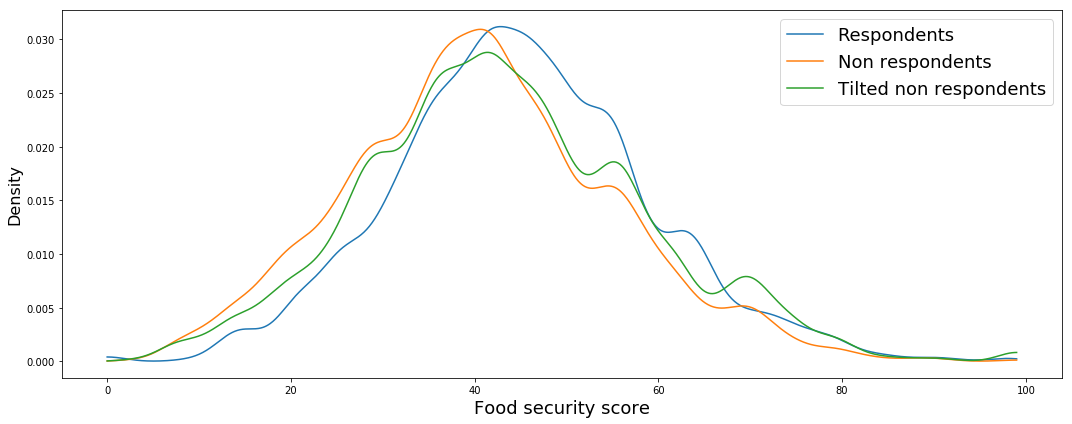

In [37]:
plt.plot(xgrid,KDE_evaluate(Y[D].values.astype(float), xgrid), label="Respondents")
plt.plot(xgrid, KDE_evaluate(Y[~D].values.astype(float), xgrid), label="Non respondents")
plt.plot(xgrid, tilted_density_eval, label="Tilted non respondents")
plt.xlabel("Food security score", fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig("Estimated_FCS_densities.png")
plt.show()

We also evaluate the tilting on the distribution on a covariate by the same method

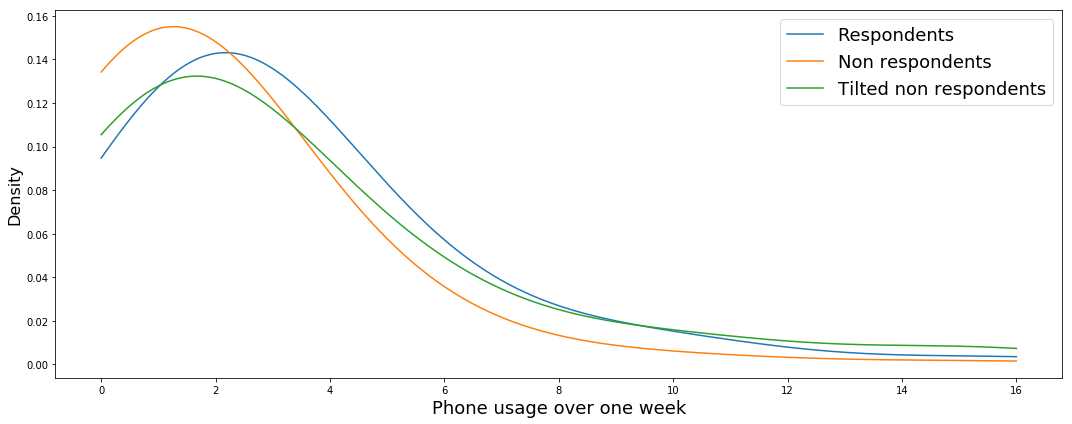

In [36]:
var = "tel_portable"
grid = np.linspace(0, 16 , 1000 )
tilted_var_eval = KDE_evaluate(df_ast.loc[~D, var], grid, weights=tilts[~D, 2], fft=False)
plt.plot(grid, KDE_evaluate(((df_ast.loc[D, var]).values).astype(float), grid), label= "Respondents")
plt.plot(grid, KDE_evaluate(((df_ast.loc[~D, var]).values).astype(float), grid), label= "Non respondents")
plt.plot(grid, tilted_var_eval, label="Tilted non respondents")
plt.xlabel("Phone usage over one week", fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig("Estimated_phone_use_densities")
plt.show()